# Project 3 - Introduction


Reddit is a social news aggregation, content rating and discussion website, where users can submit content to the site such as links, text posts, images and videos, which are then voted up or down by other members. Posts are organized by subject into user-created boards called "communities" or "subreddits". As reddit has different user-created boards called sub-reddits, each sub-reddit contains a specific topic which the users can post Questions, Comments, and Answers to.

There are a wide range of topics on reddit, from simple topics like "askreddit", where anyone can ask a question and get their answers, to more complex topics like "learnmachinelearning", where one can learn about machine learning, and even fun topics like fat cats from "Chonkers". This wide range of sub-reddits is a great way to anyone to learn and gain knowledge about a specific topic.

As a avivd user of Reddit, I have explored the different data science related sub-reddits to understand what data science is about. There are How-to-start posts where links/guides are given to help anyone interested in the topic. These said posts have helped me out when I was starting out to learn about data science, and especially on learning how to code in python. In particular, learningpython has helped me to understand more about python programming language and places where I can learn how to code, and learningmachinelearning has helped me to understand deeper on what machine-learning is, and how it is related to data science in general.

Hence, I have decided to build a classifier model to classify posts about these 2 sub-reddits. The classifier model will be based on the content of the posts, and will be able to classify the posts into 2 categories - "learn python" and "learn machine learning".

One of the use cases is that anyone can post anything into the sub-reddits, this classification model may help to suggest to the user if the question they want to ask is placed in the correct sub-reddit.

The following 2 sub-reddits were chosen,
1. learnmachinelearning [https://www.reddit.com/r/learnmachinelearning/]
2. learnpython [https://www.reddit.com/r/learnpython/]



A classification model will be built on these 2 sub-reddits posts, to be able to classify future or past posts into each 2 sub-reddits. This can help to classify the posts into the correct sub-reddit.

This is the flow of the notebook

1. Data Retrieval from the 2 sub-reddits using the Pushshift API
2. Data Analysis of the data obtained
3. Data Cleaning/ Feature Engineering
4. Data Visualization
5. Data Modeling
6. Results Evaluation
7. How does the model fare against 'future' unseen datasets?
8. Conclusion/Recommendations


In [1]:
# imports
import requests
from datetime import datetime
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
import xgboost as xgb

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
import matplotlib as mpl

plt.style.use(['tableau-colorblind10'])
from textwrap import wrap


%matplotlib inline

## Data Retrieval

In [51]:
def get_post(subreddit, current_time, size, url="https://api.pushshift.io/reddit/search/submission"):

    '''
    This function is to get the posts from the sub-reddits, and a loop is created as the max size of each iteration is 100, and size can be changed.
    '''

    posts_1 = []
    for _ in range(size):
        params = {
            "subreddit": subreddit,
            "size": 100,
            "before": current_time,
            "sort_type": "created_utc",
        }
        res = requests.get(url, params)
        if res.status_code != 200:
            print(res.status_code)
            break
        # print(res.status_code)
        data = res.json()
        posts_1.extend(data["data"])
        # print(_)
        current_time = int(posts_1[-1]["created_utc"])

        time.sleep(1)
    return pd.DataFrame(posts_1)

In [52]:
## The below has been commented out to prevent from re-running the code, as the dataframe is already saved in the data folder, as df_2.pickle

# df_learnml = get_post("learnmachinelearning", current_time=int(datetime(2022, 7, 24, 0, 0, 0).timestamp()), size=21)
# df_learnpy = get_post("learnpython", current_time=int(datetime(2022, 7, 24, 0, 0, 0).timestamp()), size=21)

# df = pd.concat([df_learnml, df_learnpy], axis=0)

# # filename = "./data/df_2.pickle"
# # with open(filename, "wb") as f:
# #     pickle.dump(df, f)

In [53]:
# Loading of the dateframe
with open("./data/df_2.pickle", 'rb') as f:
    df = pickle.load(f)

In [54]:
df.head()


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_template_id,link_flair_text,media_metadata,post_hint,preview,thumbnail_height,thumbnail_width,media,media_embed,removed_by_category,secure_media,secure_media_embed,url_overridden_by_dest,crosspost_parent,crosspost_parent_list,gallery_data,is_gallery,author_cakeday,poll_data,author_flair_background_color,author_flair_text_color,author_flair_template_id,suggested_sort
0,[],False,dummifiedme,None,[],None,text,t2_4svtgv19,False,False,False,[],False,False,1658590334,self.learnmachinelearning,https://www.reddit.com/r/learnmachinelearning/...,{},w66pyu,False,True,False,False,False,True,True,False,,[],dark,text,False,False,False,0,0,False,all_ads,/r/learnmachinelearning/comments/w66pyu/advise...,False,6,1658590344,1,"Hello fellow redditors,\n\n&amp;#x200B;\n\nAs ...",True,False,False,learnmachinelearning,t5_3cqa1,269740,public,self,Advise Needed] Mechanical engineer trying to v...,0,[],1.0,https://www.reddit.com/r/learnmachinelearning/...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,davidmezzetti,None,[],None,text,t2_536lg1nv,False,False,False,[],False,False,1658580443,self.learnmachinelearning,https://www.reddit.com/r/learnmachinelearning/...,{},w638fw,False,True,False,False,False,True,True,False,#dadada,"[{'e': 'text', 't': 'Tutorial'}]",dark,richtext,False,False,False,0,0,False,all_ads,/r/learnmachinelearning/comments/w638fw/build_...,False,6,1658580603,1,&amp;#x200B;\n\n[Search with txtai](https://i....,True,False,False,learnmachinelearning,t5_3cqa1,269741,public,https://b.thumbs.redditmedia.com/wGQ1b8PB3N2gj...,Build semantic search applications,0,[],1.0,https://www.reddit.com/r/learnmachinelearning/...,all_ads,6,8aeee882-d289-11ea-b4f0-0ed750cbd99b,Tutorial,"{'1uu82r9r1bd91': {'e': 'Image', 'id': '1uu82r...",self,"{'enabled': False, 'images': [{'id': 'AJLGUZRc...",70.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,C0R0NA_CHAN,None,[],None,text,t2_5v8kr4c5,False,False,False,[],False,False,1658579881,self.learnmachinelearning,https://www.reddit.com/r/learnmachinelearning/...,{},w6329i,False,True,False,False,False,True,True,False,#ffb000,"[{'e': 'text', 't': 'Question'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/learnmachinelearning/comments/w6329i/what_p...,False,6,1658579892,1,"So as the title suggests, I want to build a ml...",True,False,False,learnmachinelearning,t5_3cqa1,269737,public,self,What pre processing do I need to do on a video...,0,[],1.0,https://www.reddit.com/r/learnmachinelearning/...,all_ads,6,ec81b8ee-accf-11e9-b8f8-0ebea2df7d78,Question,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,JustAnAwkwardDev,None,[],None,text,t2_ec8kiwgp,False,False,False,[],False,False,1658579292,self.learnmachinelearning,https://www.reddit.com/r/learnmachinelearning/...,{},w62vlv,False,True,False,False,False,True,True,False,#ffb000,"[{'e': 'text', 't': 'Question'}]",dark,richtext,False,False,True,0,0,False,all_ads,/r/learnmachinelearning/comments/w62vlv/which_...,False,6,1658579303,1,I am an IT intern at a respected startup in La...,True,False,False,learnmachinelearning,t5_3cqa1,2

In [82]:
pd.to_datetime(df[['created_utc']].max(), unit='s')

created_utc   2022-07-23 15:55:19
dtype: datetime64[ns]

## Data Analysis

### Looking into the posts data created

In [55]:
# Change the created_utc to datetime
df["date_posted"] = pd.to_datetime(df["created_utc"], unit="s")

In [56]:
display(df.groupby("subreddit")["date_posted"].min())
display(df.groupby("subreddit")["date_posted"].max())

subreddit
learnmachinelearning   2022-05-15 15:22:37
learnpython            2022-07-05 05:49:34
Name: date_posted, dtype: datetime64[ns]

subreddit
learnmachinelearning   2022-07-23 15:32:14
learnpython            2022-07-23 15:55:19
Name: date_posted, dtype: datetime64[ns]

In [57]:
df['month_posted'] = df['date_posted'].dt.month

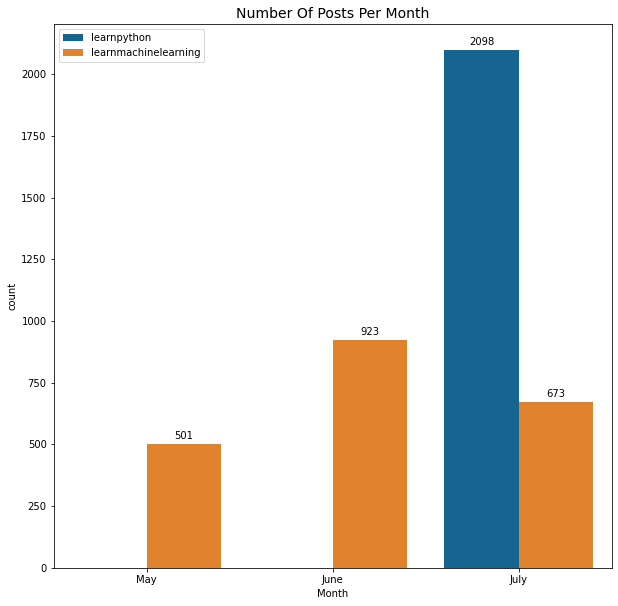

In [58]:
plt.figure(figsize=(10,10))

p = sns.countplot(
    data=df.sort_values(by='date_posted', ascending=False)[['subreddit','date_posted','month_posted']],
    x='month_posted',
    hue='subreddit',
)

p.bar_label(p.containers[0], padding=3)
p.bar_label(p.containers[1], padding=3)
plt.legend(labels=['learnpython', 'learnmachinelearning'], loc='upper left')
plt.title('Number Of Posts Per Month', fontsize=14)

plt.xticks(ticks=[0, 1, 2], labels=['May', 'June', 'July'])
plt.xlabel("Month")

plt.savefig("./charts/month_posted.png", bbox_inches="tight", facecolor='w')
plt.show()

About 2100 posts extracted are mostly from May to July, with the posts from learn python subreddit to be all found in July.
This indicates that learn python is a very active subreddit, which if you think about it, it is true, as python is a popular programming language with a lot of use cases. However, looking at learn machine learning, it is a more specialized kind of topic.

Furthermore, there are 634k followers in learnpython subreddit, and 270k followers for learnmachinelearning. This may have contributed to the more posts in the learnpython subreddit in the month of July.

In [59]:
df['subreddit'].value_counts().sum()

4195

In [60]:
df.shape

(4195, 84)

About 2100 data points were retrieved from the sub-reddits.

In [61]:
# Extraction of features requried
df_1 = df[["created_utc", "title", "selftext", "subreddit"]]

In [62]:
df_1.head()


,created_utc,title,selftext,subreddit
0,1658590334,Advise Needed] Mechanical engineer trying to v...,"Hello fellow redditors,\n\n&amp;#x200B;\n\nAs ...",learnmachinelearning
1,1658580443,Build semantic search applications,&amp;#x200B;\n\n[Search with txtai](https://i....,learnmachinelearning
2,1658579881,What pre processing do I need to do on a video...,"So as the title suggests, I want to build a ml...",learnmachinelearning
3,1658579292,Which role makes the most sense with the goal ...,I am an IT intern at a respected startup in La...,learnmachinelearning
4,1658578807,What ML method is this? It estimates Y using t...,Hi all. I came across this ML method where the...,learnmachinelearning


In [63]:
df_1.shape

(4195, 4)

In [64]:
# Check for null values in data
df_1.isna().sum()

created_utc    0
title          0
selftext       0
subreddit      0
dtype: int64

There are no null values found in the data.

### Looking into the word count for both title and selftext

In [65]:
# Creation of new columns to see the number of words in the title and selftext
df_1["title_words"] = df_1["title"].apply(lambda x: len(x.split()))
df_1['selftext_words'] = df_1["selftext"].apply(lambda x:len(x.split()))

df_1.head()

/tmp/ipykernel_18591/4173594601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["title_words"] = df_1["title"].apply(lambda x: len(x.split()))
/tmp/ipykernel_18591/4173594601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['selftext_words'] = df_1["selftext"].apply(lambda x:len(x.split()))


,created_utc,title,selftext,subreddit,title_words,selftext_words
0,1658590334,Advise Needed] Mechanical engineer trying to v...,"Hello fellow redditors,\n\n&amp;#x200B;\n\nAs ...",learnmachinelearning,9,328
1,1658580443,Build semantic search applications,&amp;#x200B;\n\n[Search with txtai](https://i....,learnmachinelearning,4,91
2,1658579881,What pre processing do I need to do on a video...,"So as the title suggests, I want to build a ml...",learnmachinelearning,25,174
3,1658579292,Which role makes the most sense with the goal ...,I am an IT intern at a respected startup in La...,learnmachinelearning,17,65
4,1658578807,What ML method is this? It estimates Y using t...,Hi all. I came across this ML method where the...,learnmachinelearning,18,94


In [66]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4195 entries, 0 to 2097
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_utc     4195 non-null   int64 
 1   title           4195 non-null   object
 2   selftext        4195 non-null   object
 3   subreddit       4195 non-null   object
 4   title_words     4195 non-null   int64 
 5   selftext_words  4195 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 229.4+ KB


In [67]:
df_1 = df_1.reset_index(drop=True)

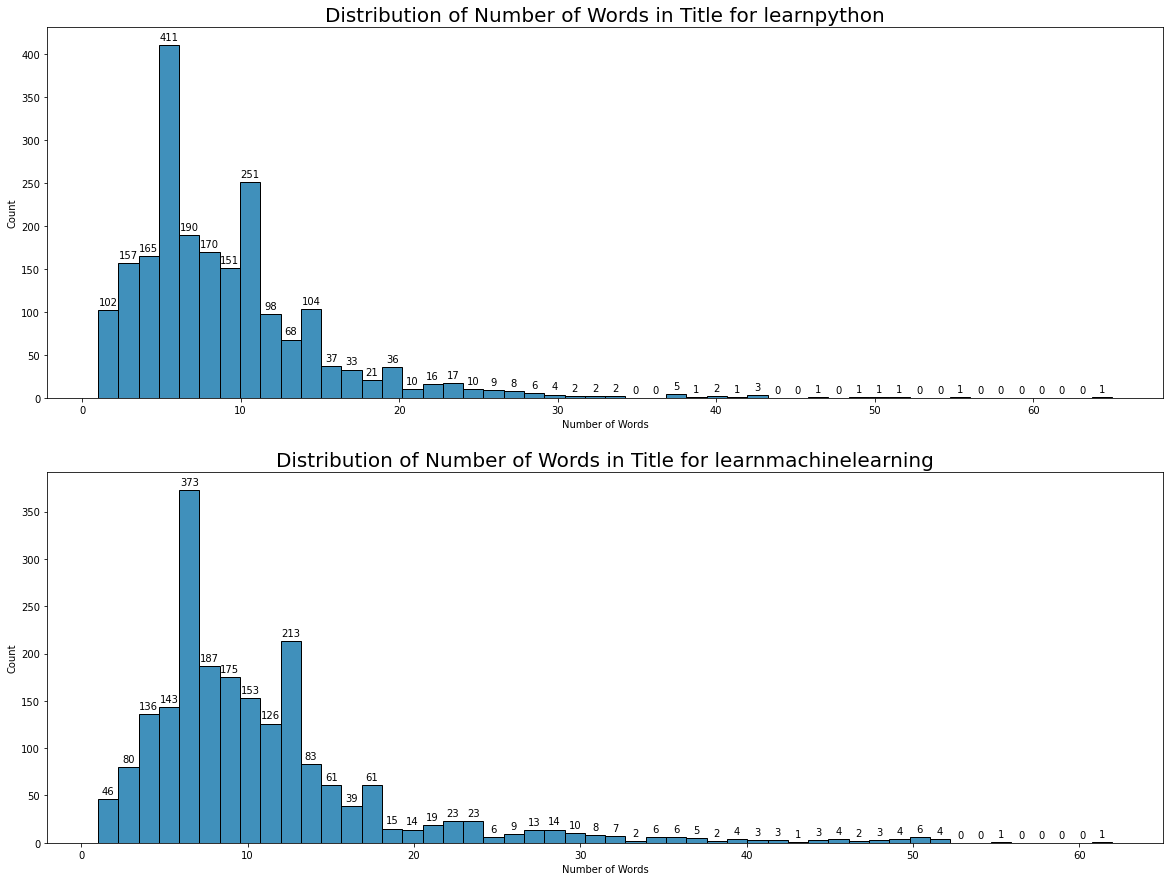

In [73]:
# Looking into the data visualizations for the number of words in the title
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15), facecolor='w')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
# plt.figure(figsize=(15,5))

df_edit = df_1.copy()
# df_edit.loc[(df_edit['title_words'] >= 50), 'title_words'] = 50

sns.histplot(
    data=df_edit.loc[(df_edit['subreddit'] == 'learnpython'), :],
    x="title_words",
    bins=50,
    ax=axes[0]
)

axes[0].bar_label(axes[0].containers[0], padding=3)
axes[0].set_title("Distribution of Number of Words in Title for learnpython", fontsize=20)
axes[0].set_xlabel("Number of Words")
# axes[0].set_xlim(0,70)

sns.histplot(
    data=df_edit.loc[(df_edit['subreddit'] == 'learnmachinelearning'), :],
    x="title_words",
    bins=50,
    ax=axes[1]
)

axes[1].bar_label(axes[1].containers[0], padding=3)
axes[1].set_title("Distribution of Number of Words in Title for learnmachinelearning", fontsize=20)
axes[1].set_xlabel("Number of Words")
# axes[1].set_xlim(0,70)

plt.savefig("./charts/title_words_count.png", bbox_inches="tight", facecolor='w')
plt.show()

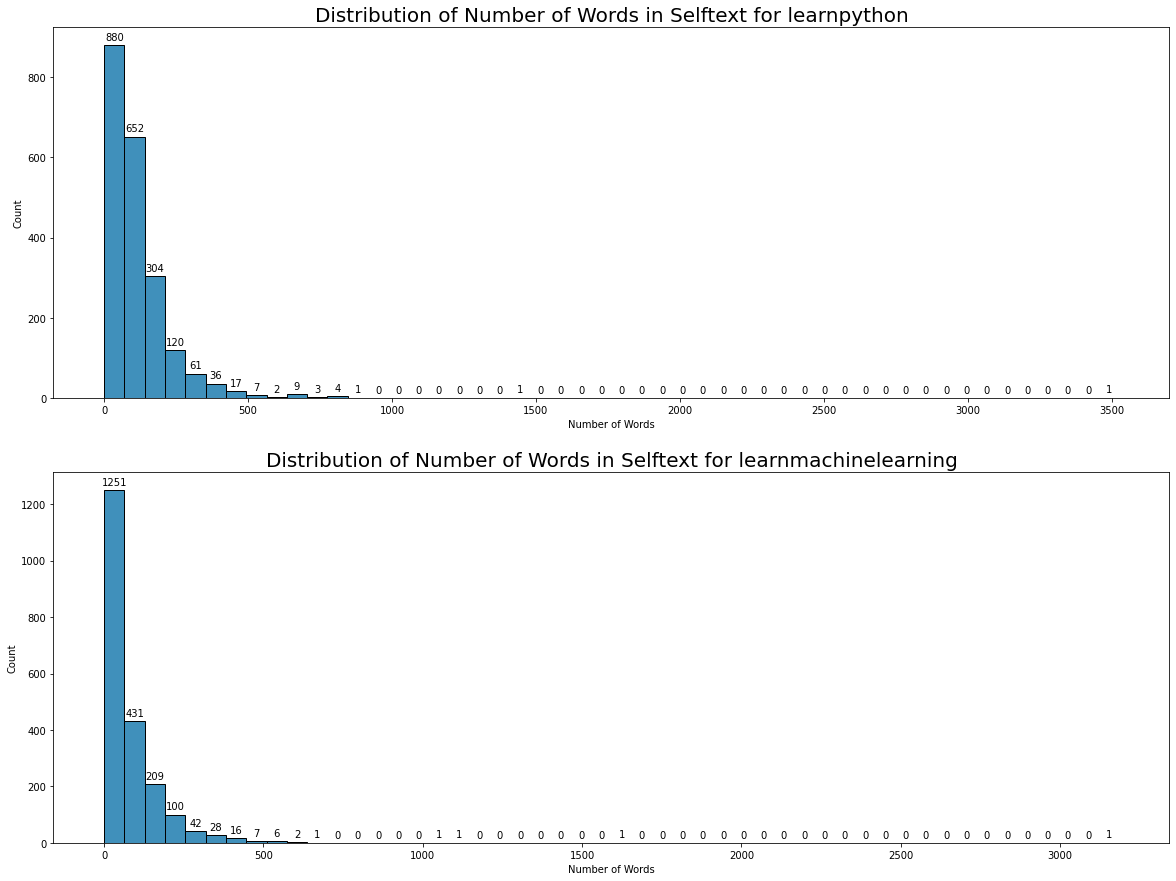

In [72]:
# Looking into1 data visualizations for the number of words in the selftext
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
# plt.figure(figsize=(15,5))

df_edit = df_1.copy()
# df_edit.loc[(df_edit['selftext_words'] >= 500), 'selftext_words'] = 500

sns.histplot(
    data=df_edit.loc[(df_edit['subreddit'] == 'learnpython'), :],
    x="selftext_words",
    bins=50,
    ax=axes[0]
)

axes[0].bar_label(axes[0].containers[0], padding=3)
axes[0].set_title("Distribution of Number of Words in Selftext for learnpython", fontsize=20)
axes[0].set_xlabel("Number of Words")
# axes[0].set_xlim(0,3500)

sns.histplot(
    data=df_edit.loc[(df_edit['subreddit'] == 'learnmachinelearning'), :],
    x="selftext_words",
    bins=50,
    ax=axes[1]
)

axes[1].bar_label(axes[1].containers[0], padding=3)
axes[1].set_title("Distribution of Number of Words in Selftext for learnmachinelearning", fontsize=20)
axes[1].set_xlabel("Number of Words")

plt.savefig("./charts/selftext_words_count.png", bbox_inches="tight", facecolor='w')

In [21]:
df_1.describe()

,created_utc,title_words,selftext_words
count,4.195000e+03,4195.000000,4195.000000
mean,1.656711e+09,9.990942,94.459595
std,1.673709e+06,7.197759,130.936674
min,1.652628e+09,1.000000,0.000000
25%,1.655635e+09,6.000000,16.000000
50%,1.657330e+09,8.000000,66.000000
75%,1.657990e+09,12.000000,129.000000
max,1.658592e+09,65.000000,3525.000000


From the describe and charts above, it is observed that:
1. There are no null values.
2. There are at least 1 word in the title, but there are some empty selftext.
3. The title words have a max of 65, while the selftext have a max of 3525.

### Further investigation

In [22]:
# Looking into title words that have only 1 word
df_1[df_1['title_words'] == 1]

,created_utc,title,selftext,subreddit,title_words,selftext_words
352,1657620930,Clustering,,learnmachinelearning,1,0
497,1657190554,เรียนภาษาจีนด้วยตัวเองep.2,,learnmachinelearning,1,0
591,1656959065,Slicing,,learnmachinelearning,1,0
980,1655790912,https://t.me/AUTOMATIZACION_OLIVER,,learnmachinelearning,1,0
983,1655787883,https://t.me/AUTOMATIZACION_OLIVER,[removed],learnmachinelearning,1,1
984,1655787849,https://t.me/AUTOMATIZACION_OLIVER,[removed],learnmachinelearning,1,1
1000,1655748260,Introduction,"Hi, what do I need to know about ML",learnmachinelearning,1,9
1057,1655590534,Prerequisites?,"Before getting into AI (courses etc.),What are...",learnmachinelearning,1,44
1371,1654663169,ADE20K,Has anyone worked with the ADE20k dataset ? DM...,learnmachinelearning,1,20
1469,1654413041,curious,hey guys... I am a computer science freshman. ...,learnmachinelearning,1,64


It seems that a lot of these title words with 1 count are mostly spam, as the moderator for that post have already removed the post, resulting in the '[removed]' in the selftext.

In [23]:
# Investigation of posts with more than 3000 words

df["title_words"] = df["title"].apply(lambda x: len(x.split()))
df['selftext_words'] = df["selftext"].apply(lambda x:len(x.split()))
with pd.option_context('display.max_colwidth', None):
    display(df.loc[(df['selftext_words'] > 3000), ['subreddit', 'url']])

,subreddit,url
1576,learnmachinelearning,https://www.reddit.com/r/learnmachinelearning/comments/v2db77/mmml_deploy_huggingface_training_model_rapidly/
148,learnpython,https://www.reddit.com/r/learnpython/comments/w56dhh/im_really_struggling_here_variable_changes/


There are some posts found with more than 3000 words, and some posts with no words/ only 1 word. 

After doing the investigation above, those with 1 word titles are mostly spam, and the moderator for that sub-reddit has already removed them. For the 3000 words, looking into the sub-reddit, it was found that the majority of the text is not spam, but is valid for usage in the modeling process. Hence, the posts will not be removed.

However, for the selftext, there are some posts with no words, but is not null in the data.

After much consideration, there are 2 ways I can take:
1) Remove the posts with no words in the selftext
2) Combine the title and selftext together

In [24]:
# Number of posts with 0 words but not null

df.loc[df['selftext_words'] == 0, :].groupby('subreddit')['selftext_words'].count()


subreddit
learnmachinelearning    687
learnpython              22
Name: selftext_words, dtype: int64

There are a total of 687 posts from learnmachinelearning and 22 from learnpython. Removing all these posts may lead to a slight data imbalance in the model.

In [25]:
df_1.shape

(4195, 6)

In [26]:
# Create a copy of the dataframe
df_x = df_1

In [27]:
# Original shape = 4195 rows
df_x.shape

(4195, 6)

In [28]:
# After dropping of the rows with 0 selftext words, total rows = 3486
df_x.drop(df_x[df_x['selftext_words'] == 0].index, inplace=True)
df_x.shape

(3486, 6)

In [29]:
# Checking the value counts
df_x['subreddit'].value_counts(normalize=True)

learnpython             0.595525
learnmachinelearning    0.404475
Name: subreddit, dtype: float64

After dropping the posts with no words in the selftext, the data is 0.59 vs 0.40. There is a slight imbalance of data here. In addition, the post is not exactly empty, as they contain links to other posts/external websites.


For example: 

<img src="./pictures/example for 0 words.png">


The post above is an example of "selftext_words = 0" shows a link to another sub-reddit at r/webdev. But the post title is still related to learnmachinelearning.

- Method decided: Combine the title and selftext together, as the removing the posts with no words will results in a sign balance of data, and the title also consists some important words.

In [30]:
# Investigation of posts with more than 3000 words

df["title_words"] = df["title"].apply(lambda x: len(x.split()))
df['selftext_words'] = df["selftext"].apply(lambda x:len(x.split()))
with pd.option_context('display.max_colwidth', None):
    display(df.loc[(df['selftext_words'] > 3000), ['title','subreddit', 'url',]])

,title,subreddit,url
1576,MMML | Deploy HuggingFace training model rapidly based on MetaSpore,learnmachinelearning,https://www.reddit.com/r/learnmachinelearning/comments/v2db77/mmml_deploy_huggingface_training_model_rapidly/
148,"I'm really struggling here. Variable changes without being reassigned a new value. I have no idea what's going on. Really long post, but I tried to make it as detailed as possible. Huge thank you to anyone who can figure this one out!",learnpython,https://www.reddit.com/r/learnpython/comments/w56dhh/im_really_struggling_here_variable_changes/


The links above were entered, and found that the posts are related to the sub-reddits. Hence, they will not be removed, and used in the modeling process.

## Data Cleaning/ Engineering

From the previous analysis, the following steps will be taken:
1. Remove the posts with '[removed]' in the selftext
2. Combine the title and the selftext together

In [31]:
# Removal of posts with removed in selftext
df_1.drop(df_1[df_1["selftext"] == "[removed]"].index, inplace=True)

In [32]:
df_1.shape


(3353, 6)

In [33]:
df_1['subreddit'].value_counts(normalize=True)

learnpython             0.599463
learnmachinelearning    0.400537
Name: subreddit, dtype: float64

In [34]:
# Combination of title and selftext
df_1['combined'] = df_1['title'] + " " + df_1['selftext']

In [35]:
## Checking of data
# with pd.option_context('display.max_colwidth', None):
#     display(df_1['combined'])

In [36]:
df_1.head()

,created_utc,title,selftext,subreddit,title_words,selftext_words,combined
0,1658590334,Advise Needed] Mechanical engineer trying to v...,"Hello fellow redditors,\n\n&amp;#x200B;\n\nAs ...",learnmachinelearning,9,328,Advise Needed] Mechanical engineer trying to v...
1,1658580443,Build semantic search applications,&amp;#x200B;\n\n[Search with txtai](https://i....,learnmachinelearning,4,91,Build semantic search applications &amp;#x200B...
2,1658579881,What pre processing do I need to do on a video...,"So as the title suggests, I want to build a ml...",learnmachinelearning,25,174,What pre processing do I need to do on a video...
3,1658579292,Which role makes the most sense with the goal ...,I am an IT intern at a respected startup in La...,learnmachinelearning,17,65,Which role makes the most sense with the goal ...
4,1658578807,What ML method is this? It estimates Y using t...,Hi all. I came across this ML method where the...,learnmachinelearning,18,94,What ML method is this? It estimates Y using t...


In [37]:
# Change the predictor to 0 and 1
df_1["subreddit"] = df_1["subreddit"].map({"learnpython": 0, "learnmachinelearning": 1})
df_1.head()

,created_utc,title,selftext,subreddit,title_words,selftext_words,combined
0,1658590334,Advise Needed] Mechanical engineer trying to v...,"Hello fellow redditors,\n\n&amp;#x200B;\n\nAs ...",1,9,328,Advise Needed] Mechanical engineer trying to v...
1,1658580443,Build semantic search applications,&amp;#x200B;\n\n[Search with txtai](https://i....,1,4,91,Build semantic search applications &amp;#x200B...
2,1658579881,What pre processing do I need to do on a video...,"So as the title suggests, I want to build a ml...",1,25,174,What pre processing do I need to do on a video...
3,1658579292,Which role makes the most sense with the goal ...,I am an IT intern at a respected startup in La...,1,17,65,Which role makes the most sense with the goal ...
4,1658578807,What ML method is this? It estimates Y using t...,Hi all. I came across this ML method where the...,1,18,94,What ML method is this? It estimates Y using t...


## Data Visualizations

In [38]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
py_words = WordCloud(
    background_color='white',
    stopwords=stopwords,
)

<Figure size 2000x2000 with 0 Axes>

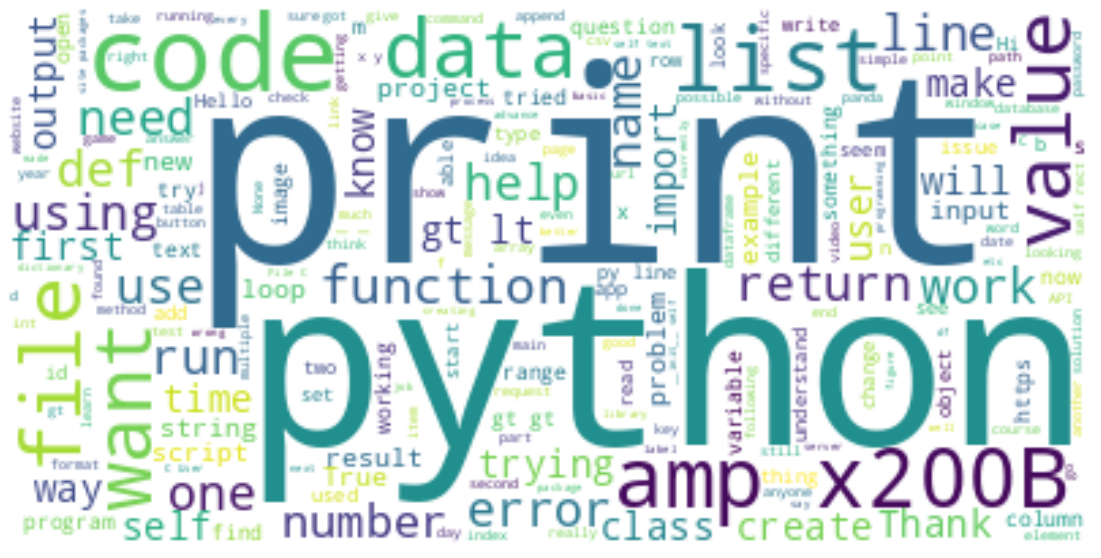

In [39]:
plt.figure(figsize=(10,10), dpi=200)

py_words.generate(df_1.loc[df_1['subreddit']==0, 'combined'].str.cat(sep=' '))

plt.figure(figsize=(20,10))
plt.imshow(py_words, interpolation='bilinear')
plt.axis('off')

plt.savefig("./charts/learningpython_wordcloud.png", bbox_inches="tight", facecolor='w')
plt.show()

<Figure size 2000x2000 with 0 Axes>

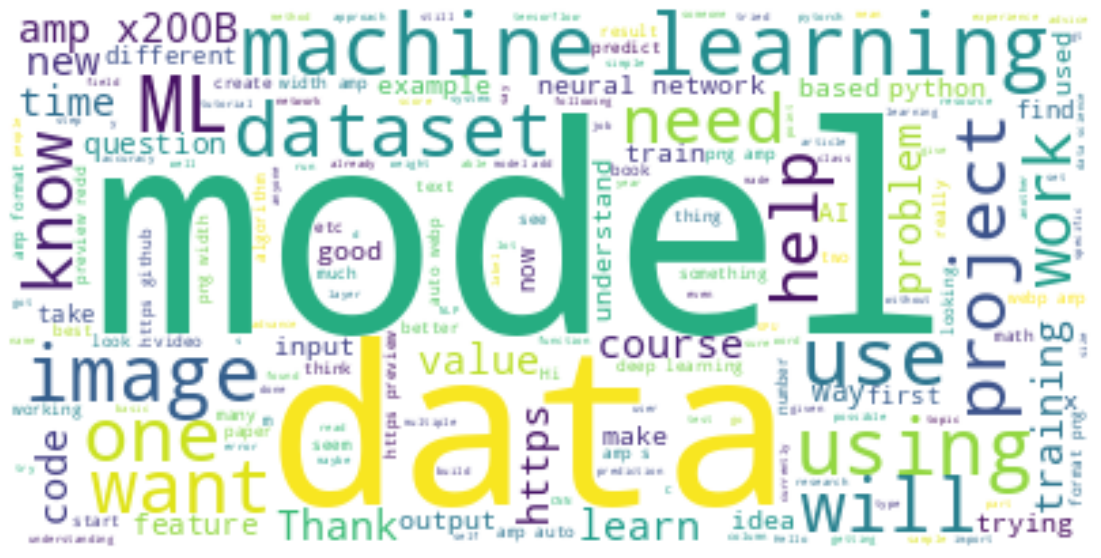

In [40]:
plt.figure(figsize=(10,10), dpi=200, facecolor='w')

py_words.generate(df_1.loc[df_1['subreddit']==1, 'combined'].str.cat(sep=' '))

plt.figure(figsize=(20,10))
plt.imshow(py_words, interpolation='bilinear')
plt.axis('off')

plt.savefig("./charts/learningmachinglearning_wordcloud.png", bbox_inches="tight", facecolor='w')
plt.show()

Comparing the 2 word clouds:
1. learningpython will obviously give words related to python programming language, and we can see that print is used often.
2. learningmachinelearning will give words related to machine learning and deep learning, with words like model, data appearing.

In [41]:
# Importing the stop words
from nltk.corpus import stopwords
set(stopwords.words('english'))

stop_words = set(stopwords.words('english'))

In [42]:
# Tokenizing the stop_words before usage, as I was getting a UserWarning error that my stop_words may be inconsistent with your preprocessing
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}')
tokenized_stop_words = tokenizer.tokenize(' '.join(stop_words))

class Tokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
        
    def _stem(self, token):
        if (token in stop_words):
            return token  # Solves error "UserWarning: Your stop_words may be inconsistent with your preprocessing."
        return self.stemmer.stem(token)
        
    def __call__(self, line):
        tokens = tokenizer.tokenize(line)
        # x = re.sub(r'http\S+', '', x)
        tokens = (self._stem(token) for token in tokens)  # Stemming
        return list(tokens)

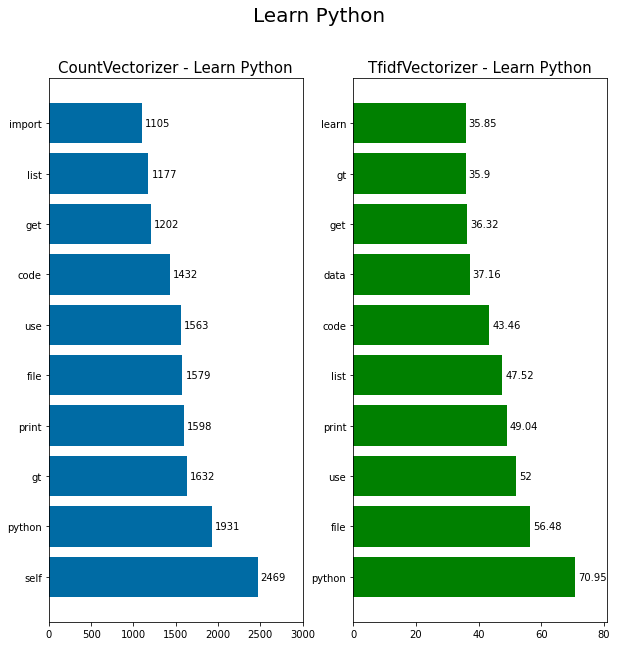

In [47]:
# To use countvect and tfidfvect to compare the words in the same posts
cus = CountVectorizer(stop_words=tokenized_stop_words, tokenizer=Tokenizer(), token_pattern=None)
cus.fit(df_1.loc[df_1['subreddit']==0, 'combined'])

x = pd.DataFrame(cus.transform(df_1.loc[df_1['subreddit']==0, 'combined']).todense(), columns=cus.get_feature_names_out())

tfidf = TfidfVectorizer(stop_words=tokenized_stop_words, tokenizer=Tokenizer(), token_pattern=None)
tfidf.fit(df_1.loc[df_1['subreddit']==0, 'combined'])

x1 = pd.DataFrame(tfidf.transform(df_1.loc[df_1['subreddit']==0, 'combined']).todense(), columns=cus.get_feature_names_out())

# Plotting of bar charts
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

ax1.barh(
    y=x.sum().sort_values(ascending=False).head(10).index,
    width=x.sum().sort_values(ascending=False).head(10),
)
ax1.set_title("CountVectorizer - Learn Python", fontsize=15)
ax1.bar_label(ax1.containers[0], padding=3)
ax1.set_xlim(0,3000)

ax2.barh(
    y=x1.sum().sort_values(ascending=False).head(10).index,
    width=x1.sum().sort_values(ascending=False).head(10).values.round(2), color='g'
)
ax2.set_title("TfidfVectorizer - Learn Python", fontsize=15)
ax2.bar_label(ax2.containers[0], padding=3)
ax2.set_xlim(0,81)

fig.suptitle("Learn Python", fontsize=20)
plt.savefig("./charts/learn_python_compare.png", bbox_inches="tight", facecolor='w')
plt.show()

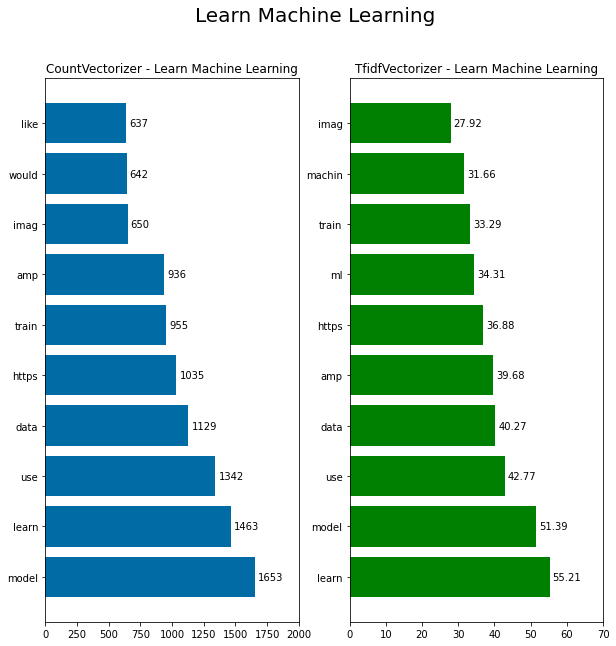

In [48]:
# To use countvect and tfidfvect to compare the words in the same posts
cus = CountVectorizer(stop_words=tokenized_stop_words, tokenizer=Tokenizer(), token_pattern=None)
cus.fit(df_1.loc[df_1['subreddit']==1, 'combined'])

x = pd.DataFrame(cus.transform(df_1.loc[df_1['subreddit']==1, 'combined']).todense(), columns=cus.get_feature_names_out())

tfidf = TfidfVectorizer(stop_words=tokenized_stop_words, tokenizer=Tokenizer(), token_pattern=None)
tfidf.fit(df_1.loc[df_1['subreddit']==1, 'combined'])

x1 = pd.DataFrame(tfidf.transform(df_1.loc[df_1['subreddit']==1, 'combined']).todense(), columns=cus.get_feature_names_out())

# To plot the charts
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

ax1.barh(
    y=x.sum().sort_values(ascending=False).head(10).index,
    width=x.sum().sort_values(ascending=False).head(10),
)
ax1.set_title("\n".join(wrap("CountVectorizer - Learn Machine Learning", 40)))
ax1.bar_label(ax1.containers[0], padding=3)
ax1.set_xlim(0,2000)

ax2.barh(
    y=x1.sum().sort_values(ascending=False).head(10).index,
    width=x1.sum().sort_values(ascending=False).head(10).values.round(2), color='g'
)
ax2.set_title("\n".join(wrap("TfidfVectorizer - Learn Machine Learning", 40)))
ax2.bar_label(ax2.containers[0], padding=3)
ax2.set_xlim(0,70)

fig.suptitle("Learn Machine Learning", fontsize=20)
plt.savefig("./charts/learn_machine_learning_compare.png", bbox_inches='tight', facecolor='w')
plt.show()

Comparing both Count Vectorizer and TF-IDF Vectorizer, the words obtained are roughly the same, with the exception of the 'self' word in the learn python.

From this, we can see that the content in learn python most consists of code-like words (print and self), while the content in learn machine learning is more of a context type of words, which has learn and model.

## Data Modeling

In [45]:
df_1.head()

,created_utc,title,selftext,subreddit,title_words,selftext_words,combined
0,1658590334,Advise Needed] Mechanical engineer trying to v...,"Hello fellow redditors,\n\n&amp;#x200B;\n\nAs ...",1,9,328,Advise Needed] Mechanical engineer trying to v...
1,1658580443,Build semantic search applications,&amp;#x200B;\n\n[Search with txtai](https://i....,1,4,91,Build semantic search applications &amp;#x200B...
2,1658579881,What pre processing do I need to do on a video...,"So as the title suggests, I want to build a ml...",1,25,174,What pre processing do I need to do on a video...
3,1658579292,Which role makes the most sense with the goal ...,I am an IT intern at a respected startup in La...,1,17,65,Which role makes the most sense with the goal ...
4,1658578807,What ML method is this? It estimates Y using t...,Hi all. I came across this ML method where the...,1,18,94,What ML method is this? It estimates Y using t...


In [46]:
# Train test split
X = df_1[["combined"]]
y = df_1["subreddit"]

In [47]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [48]:
X_train.shape

(2347, 1)

In [49]:
X_train.head()

,combined
3417,"If variable ""y"" within function F(x,y) calls t..."
2136,property() does not work with public attribute...
2677,"Returning multiple arguments Hello guys, I am ..."
1394,Looking for advice on how to spend two weeks l...
1579,Is it possible to tell if a data set is linear...


In [50]:
y_train.value_counts(normalize=True)

0    0.599489
1    0.400511
Name: subreddit, dtype: float64

### Pipeline and Parameters Preparation

In [51]:
# Random Forest Classifier

pipeline_cvec_rf = Pipeline([
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'combined')])),
    ('rf', RandomForestClassifier())
])

pipeline_tfidf_rf = Pipeline([
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'combined')])),
    ('rf', RandomForestClassifier())
])

params_cvec_rf = {
    'ct__cvec__tokenizer': [Tokenizer()],
    'ct__cvec__max_features': [1000, 1500, 2000],
    'ct__cvec__stop_words': [tokenized_stop_words, None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [0, 0.50, 0.95],
    'ct__cvec__min_df': [0, 0.10, 0.25],
    'rf__max_depth': [2, 3, 4],
    'rf__n_estimators': [100, 200, 300],
    'rf__random_state': [42]
}

params_tfidf_rf = {
    'ct__tfidf__tokenizer': [Tokenizer()],
    'ct__tfidf__max_features': [1000, 1500, 2000],
    'ct__tfidf__stop_words': [tokenized_stop_words, None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [0, 0.50, 0.95],
    'ct__tfidf__min_df': [0, 0.10, 0.25],
    'rf__max_depth': [2, 3, 4],
    'rf__n_estimators': [100, 200, 300],
    'rf__random_state': [42]
}

In [52]:
# Navie Bayes Classifier

pipeline_cvec_nb = Pipeline([
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'combined')])),
    ('nb', MultinomialNB())
])

pipeline_tfidf_nb = Pipeline([
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'combined')])),
    ('nb', MultinomialNB())
])

params_cvec_nb = {
    'ct__cvec__tokenizer': [Tokenizer()],
    'ct__cvec__max_features': [1000, 1500, 2000],
    'ct__cvec__stop_words': [tokenized_stop_words, None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [0, 0.50, 0.95],
    'ct__cvec__min_df': [0, 0.10, 0.25],
    'nb__alpha': [0.1, 0.5, 0.9]
}



params_tfidf_nb = {
    'ct__tfidf__tokenizer': [Tokenizer()],
    'ct__tfidf__max_features': [1000, 1500, 2000],
    'ct__tfidf__stop_words': [tokenized_stop_words, None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [0, 0.50, 0.95],
    'ct__tfidf__min_df': [0, 0.10, 0.25],
    'nb__alpha': [0.1, 0.5, 0.9]
}

In [53]:
# SGDClassifier

pipeline_cvec_sgd = Pipeline([
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'combined')])),
    ('sgd', SGDClassifier())
])

pipeline_tfidf_sgd = Pipeline([
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'combined')])),
    ('sgd', SGDClassifier())
])

params_cvec_sgd = {
    'ct__cvec__tokenizer': [Tokenizer()],
    'ct__cvec__max_features': [1000, 1500, 2000],
    'ct__cvec__stop_words': [tokenized_stop_words, None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [0, 0.5, 0.95],
    'ct__cvec__min_df': [0, 0.10, 0.25],
    'sgd__loss' : ['hinge', 'log_loss'],
    'sgd__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10],
}

params_tfidf_sgd = {
    'ct__tfidf__tokenizer': [Tokenizer()],
    'ct__tfidf__max_features': [1000, 1500, 2000],
    'ct__tfidf__stop_words': [tokenized_stop_words, None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [0, 0.5, 0.95],
    'ct__tfidf__min_df': [0, 0.10, 0.25],
    'sgd__loss' : ['hinge', 'log_loss'],
    'sgd__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10],
}

In [54]:
# Adaboost

pipeline_cvec_ada = Pipeline([
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'combined')])),
    ('ada', AdaBoostClassifier())
])

pipeline_tfidf_ada = Pipeline([
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'combined')])),
    ('ada', AdaBoostClassifier())
])

params_cvec_ada = {
    'ct__cvec__tokenizer': [Tokenizer()],
    'ct__cvec__max_features': [1000, 1500, 2000],
    'ct__cvec__stop_words': [tokenized_stop_words, None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [0, 0.5, 0.95],
    'ct__cvec__min_df': [0, 0.10, 0.25],
    'ada__n_estimators': [25, 50, 100],
    'ada__random_state': [42],
    'ada__learning_rate' : [0.5, 1.0, 1.5],

}

params_tfidf_ada = {
    'ct__tfidf__tokenizer': [Tokenizer()],
    'ct__tfidf__max_features': [1000, 1500, 2000],
    'ct__tfidf__stop_words': [tokenized_stop_words, None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [0, 0.5, 0.95],
    'ct__tfidf__min_df': [0, 0.10, 0.25],
    'ada__n_estimators': [25, 50, 100],
    'ada__random_state': [42],
    'ada__learning_rate' : [0.5, 1.0, 1.5],
}



In [55]:
# xgboost
pipeline_cvec_xgb = Pipeline([
    ('ct', ColumnTransformer([('cvec', CountVectorizer(), 'combined')])),
    ('xgb', xgb.XGBClassifier())
])

pipeline_tfidf_xgb = Pipeline([
    ('ct', ColumnTransformer([('tfidf', TfidfVectorizer(), 'combined')])),
    ('xgb', xgb.XGBClassifier())
])

params_cvec_xgb = {
    'ct__cvec__tokenizer': [Tokenizer()],
    'ct__cvec__max_features': [1000, 1500, 2000],
    'ct__cvec__stop_words': [tokenized_stop_words, None],
    'ct__cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__cvec__max_df': [0, 0.50, 0.95],
    'ct__cvec__min_df': [0, 0.10, 0.25],
    'xgb__eta': [0.1, 0.5, 1],
    'xgb__max_depth': [2, 3, 4],
    'xgb__tree_method' : ['gpu_hist'],
}

params_tfidf_xgb = {
    'ct__tfidf__tokenizer': [Tokenizer()],
    'ct__tfidf__max_features': [1000, 1500, 2000],
    'ct__tfidf__stop_words': [tokenized_stop_words, None],
    'ct__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'ct__tfidf__max_df': [0, 0.50, 0.95],
    'ct__tfidf__min_df': [0, 0.10, 0.25],
    'xgb__eta': [0.1, 0.5, 1],
    'xgb__max_depth': [2, 3, 4],
    'xgb__tree_method' : ['gpu_hist'],
}


In [56]:
# Function to conduct grid search on pipeline
def modeling(pipeline, param_grid, model_name="", scoring="accuracy", cv=3):

    '''
    Function to conduct grid search on the pipeline, and to pickle the best model
    '''
    
    gs = GridSearchCV(
        pipeline, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1
    )

    gs.fit(X_train, y_train)

    filename = f'./model_results/{model_name}_trained.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(gs, f)

In [57]:
# Function to plot confusion matrix and obtain the metrics into a dataframe

def results_extraction(model_name=""):

    '''
    Function to extract the pickle-ed model and to conduct predictions with X_test, saving the final results to a separate dataframe
    '''
    
    filename = f'./model_results/{model_name}_trained.pickle'
    with open(filename, 'rb') as f:
        model = pickle.load(f)

    y_pred = model.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=['learnpython', 'learnmachinelearning']).plot(cmap='Blues')

    # 0 is python, 1 is ml
    plt.title(f'{model_name}: Confusion Matrix')
    plt.savefig(f"./confusion_matrix/{model_name}_confusion_matrix.png", bbox_inches='tight', facecolor='w')
    plt.close()

    # Different metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    misclassification = 1 - accuracy
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * recall) / (precision + recall)

    acc_diff = np.abs((model.score(X_train, y_train) - model.score(X_test, y_test))) / model.score(X_train, y_train)

    # Metrics for roc curve and auc
    pred_prob = model.predict_proba(X_test)
    train_prob = model.predict_proba(X_train)

    # fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    pred_auc_score = roc_auc_score(y_test, pred_prob[:,1])
    train_auc_score = roc_auc_score(y_train, train_prob[:,1])
    auc_diff = np.abs((train_auc_score - pred_auc_score)) / train_auc_score

    # Append all above results to 'results' dictionary
    results[model_name] = [
        # model.best_params_,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        misclassification,
        recall,
        specificity,
        precision,
        f1,
        train_auc_score,
        pred_auc_score,
        auc_diff,
        acc_diff
    ]

In [58]:
# Placing the models into each turple for looping
pipeline_models = [
    (pipeline_cvec_rf, params_cvec_rf, "cvec_rf"),
    (pipeline_tfidf_rf, params_tfidf_rf, "tfidf_rf"),
    (pipeline_cvec_nb, params_cvec_nb, "cvec_nb"),
    (pipeline_tfidf_nb, params_tfidf_nb, "tfidf_nb"),
    (pipeline_cvec_sgd, params_cvec_sgd, "cvec_sgd"),
    (pipeline_tfidf_sgd, params_tfidf_sgd, "tfidf_sgd"),
    (pipeline_cvec_ada, params_cvec_ada, "cvec_ada"),
    (pipeline_tfidf_ada, params_tfidf_ada, "tfidf_ada"),
    (pipeline_cvec_xgb, params_cvec_xgb, "cvec_xgb"),
    (pipeline_tfidf_xgb, params_tfidf_xgb, "tfidf_xgb"),
]

In [59]:
# # Avoid running this, as it takes about 307 minutes to run
# import warnings
# warnings.simplefilter('ignore', UserWarning)

# for model in pipeline_models:
#     modeling(pipeline=model[0], param_grid=model[1], model_name=model[2], cv=3, scoring="accuracy")

### Stacking

In [59]:
# Before stacking is attempted, extraction of the best params from the models run above
results = {}

for m in pipeline_models:
    results_extraction(model_name=m[2])

In [60]:
results_df = pd.DataFrame(results, columns=["cvec_rf", "tfidf_rf", "cvec_nb", "tfidf_nb", "cvec_sgd", "tfidf_sgd", "cvec_ada", "tfidf_ada", "cvec_xgb", "tfidf_xgb"], index=["train_score", "test_score", "misclassification", "recall", "specificity", "precision", "f1", "train_auc_score", "pred_auc_score", "auc_diff", "acc_diff"]).T

results_df.sort_values(by='auc_diff', ascending=True)

,train_score,test_score,misclassification,recall,specificity,precision,f1,train_auc_score,pred_auc_score,auc_diff,acc_diff
tfidf_xgb,0.946741,0.955268,0.044732,0.952854,0.956882,0.936585,0.944649,0.988732,0.988260,0.000478,0.009008
tfidf_ada,0.941628,0.947316,0.052684,0.928040,0.960199,0.939698,0.933833,0.985440,0.986373,0.000947,0.006041
cvec_sgd,0.965914,0.960239,0.039761,0.957816,0.961857,0.943765,0.950739,0.990385,0.988507,0.001897,0.005876
tfidf_sgd,0.954836,0.957256,0.042744,0.942928,0.966833,0.950000,0.946451,0.985768,0.988161,0.002428,0.002535
cvec_ada,0.932254,0.948310,0.051690,0.945409,0.950249,0.927007,0.936118,0.982223,0.985344,0.003178,0.017223
cvec_xgb,0.977418,0.968191,0.031809,0.970223,0.966833,0.951338,0.960688,0.994927,0.991661,0.003283,0.009440
tfidf_nb,0.936089,0.941352,0.058648,0.950372,0.935323,0.907583,0.928485,0.981997,0.986062,0.004140,0.005623
cvec_nb,0.906263,0.910537,0.089463,0.977667,0.865672,0.829474,0.897494,0.975684,0.980920,0.005367,0.004715
tfidf_rf,0.922454,0.918489,0.081511,0.937965,0.905473,0.868966,0.902148,0.974845,0.980634,0.005938,0.004298
cvec_rf,0.912654,0.922465,0.077535,0.942928,0.908789,0.873563,0.906921,0.973898,0.980890,0.007179,0.010750


From the auc scoring comparsion, the smallest auc difference comes from tfidf_xgb for tfidf, and cvec_sgd for cvec, showing that it generalises well with the training data.

In [61]:
# Obtaining the best params for the chosen models to use with stacking
# nb, rf and sgd for both cvec and tfidf as they have the top 3 lowest auc scores

for c in ['cvec_nb', 'cvec_rf', 'cvec_sgd', 'cvec_ada', 'cvec_xgb']:
    with open(f"./model_results/{c}_trained.pickle", 'rb') as f:
        model = pickle.load(f)
        print(f"{c} : {model.best_params_} \n")


for c in ['tfidf_nb', 'tfidf_rf', 'tfidf_sgd', 'tfidf_ada', 'tfidf_xgb']:
    with open(f"./model_results/{c}_trained.pickle", 'rb') as f:
        model = pickle.load(f)
        print(f"{c} : {model.best_params_} \n")

cvec_nb : {'ct__cvec__max_df': 0.5, 'ct__cvec__max_features': 2000, 'ct__cvec__min_df': 0, 'ct__cvec__ngram_range': (1, 2), 'ct__cvec__stop_words': ['me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'you', 're', 'you', 've', 'you', 'll', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'she', 'her', 'hers', 'herself', 'it', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'that', 'll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',

In [95]:
# Stacking for countvectorizer
vec = CountVectorizer(tokenizer=Tokenizer(), max_features=2000, stop_words=tokenized_stop_words, ngram_range=(1,2), max_df=0.5, min_df=0)

# Models used based on the roc-auc scores, are cvec_sgd, cvec_rf and cvec_nb
model = Pipeline([
    ('ct', ColumnTransformer([('cvec', vec, 'combined')])),
    ('clf', StackingClassifier(estimators=[
        ('xgb', xgb.XGBClassifier(eta=0.5, max_depth=4)),
        ('ada', AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)),
        ('sgd', SGDClassifier(alpha=0.01, loss='log_loss'))],
        final_estimator=LogisticRegression(),
        cv=3))
    ])

model.fit(X_train, y_train)

filename = f'./model_results/cvec_stacking_trained.pickle'
with open(filename, 'wb') as f:
    pickle.dump(model, f)

In [96]:
# Stacking for tfidfvectorizer
results = {}
vec = TfidfVectorizer(tokenizer=Tokenizer(), max_features=2000, stop_words=tokenized_stop_words, ngram_range=(1,2), max_df=0.5, min_df=0)

# Models used based on the roc-auc scores, are tfidf_sgd, tfidf_rf and tfidf_nb
model = Pipeline([
    ('ct', ColumnTransformer([('tfidf', vec, 'combined')])),
    ('clf', StackingClassifier(estimators=[
        ('xgb', xgb.XGBClassifier(eta=0.1, max_depth=4)),
        ('ada', AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)),
        ('sgd', SGDClassifier(alpha=0.001, loss='log_loss'))],
        final_estimator=LogisticRegression(),
        cv=3))
    ])

model.fit(X_train, y_train)

filename = f'./model_results/tfidf_stacking_trained.pickle'
with open(filename, 'wb') as f:
    pickle.dump(model, f)

In [177]:
all_models = []
for m in pipeline_models:
    all_models.append(m[2])
all_models.append('cvec_stacking')
all_models.append('tfidf_stacking')

# all_models

In [178]:
results = {}

for m in all_models:
    results_extraction(model_name=m)

In [179]:
# Put the final results into a df and pickle it
final_results = pd.DataFrame(results, columns=all_models, index=["train_score", "test_score", "misclassification", "recall", "specificity", "precision", "f1", "train_auc_score", "pred_auc_score", "auc_diff", "acc_diff"]).T

final_results.sort_values(by='auc_diff', ascending=True)

,train_score,test_score,misclassification,recall,specificity,precision,f1,train_auc_score,pred_auc_score,auc_diff,acc_diff
tfidf_xgb,0.946741,0.955268,0.044732,0.952854,0.956882,0.936585,0.944649,0.988732,0.988260,0.000478,0.009008
tfidf_ada,0.941628,0.947316,0.052684,0.928040,0.960199,0.939698,0.933833,0.985440,0.986373,0.000947,0.006041
cvec_sgd,0.965914,0.960239,0.039761,0.957816,0.961857,0.943765,0.950739,0.990385,0.988507,0.001897,0.005876
tfidf_sgd,0.954836,0.957256,0.042744,0.942928,0.966833,0.950000,0.946451,0.985768,0.988161,0.002428,0.002535
cvec_ada,0.932254,0.948310,0.051690,0.945409,0.950249,0.927007,0.936118,0.982223,0.985344,0.003178,0.017223
cvec_xgb,0.977418,0.968191,0.031809,0.970223,0.966833,0.951338,0.960688,0.994927,0.991661,0.003283,0.009440
tfidf_nb,0.936089,0.941352,0.058648,0.950372,0.935323,0.907583,0.928485,0.981997,0.986062,0.004140,0.005623
cvec_nb,0.906263,0.910537,0.089463,0.977667,0.865672,0.829474,0.897494,0.975684,0.980920,0.005367,0.004715
tfidf_rf,0.922454,0.918489,0.081511,0.937965,0.905473,0.868966,0.902148,0.974845,0.980634,0.005938,0.004298
cvec_rf,0.912654,0.922465,0.077535,0.942928,0.908789,0.873563,0.906921,0.973898,0.980890,0.007179,0.010750


In [100]:
with open('./data/final_results.pickle', 'wb') as f:
    pickle.dump(final_results, f)

## Results Evaulation

In [59]:
with open('./data/final_results.pickle', 'rb') as f:
    final_results = pickle.load(f)

# Obtaining the models for cvec or tfidf    
cvec_models = [i for i in final_results.index.to_list() if i.startswith('cvec')]

tfidf_models = [i for i in final_results.index.to_list() if i.startswith('tfidf')]

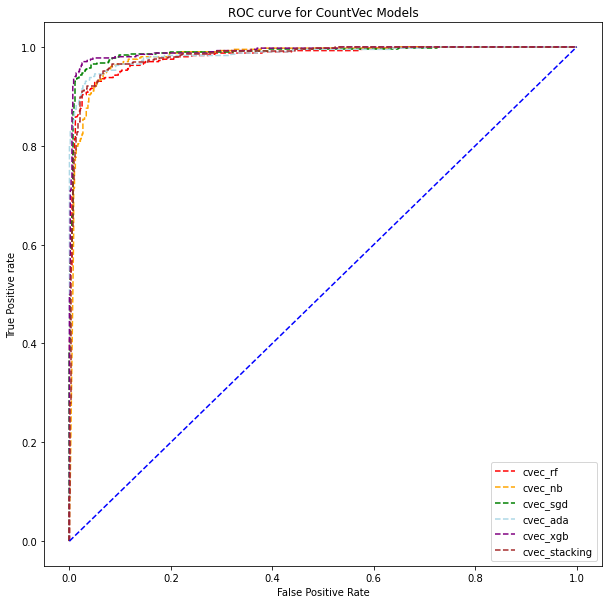

In [60]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

colors = [
    'red',
    'orange',
    'green',
    'lightblue',
    'purple',
    'brown',
    'pink'
]

plt.figure(figsize=(10,10))
for count, value in enumerate(cvec_models):
    with open(f"./model_results/{value}_trained.pickle", "rb") as f:
        model = pickle.load(f)
    pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    plt.plot(fpr, tpr, color=colors[count], label=value, linestyle='--')

# # plot roc curves
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve for CountVec Models')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('./charts/ROC_cvec.png',bbox_inches='tight', dpi=300, facecolor='w')
plt.show();

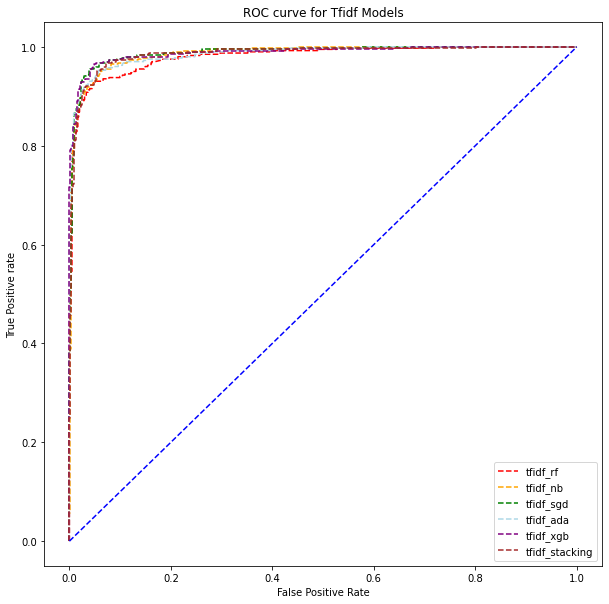

In [61]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

colors = [
    'red',
    'orange',
    'green',
    'lightblue',
    'purple',
    'brown',
    'pink'
]

plt.figure(figsize=(10,10))
for count, value in enumerate(tfidf_models):
    with open(f"./model_results/{value}_trained.pickle", "rb") as f:
        model = pickle.load(f)
    pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    plt.plot(fpr, tpr, color=colors[count], label=value, linestyle='--')

# # plot roc curves
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
# plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve for Tfidf Models')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('./charts/ROC_tfidf.png',bbox_inches='tight', dpi=300, facecolor='w')
plt.show();

The ROC curve for all the models, either count or tfidf, shows that all models are able to predict well, with only slight difference between them.

In [66]:
with open('./data/final_results.pickle', 'rb') as f:
    final_results = pickle.load(f)

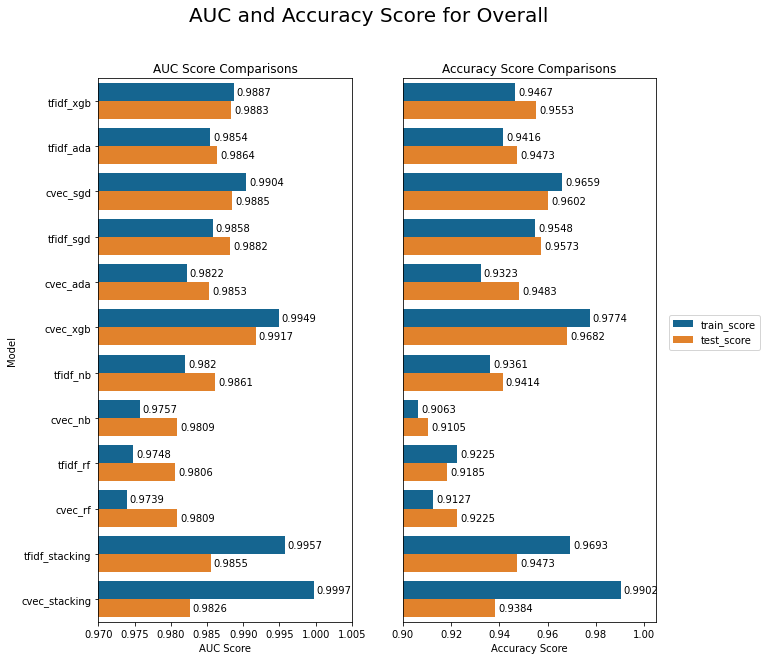

In [217]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

# Overall AUC comparison

tidy = final_results.reset_index()[['index', 'train_auc_score', 'pred_auc_score']].melt(id_vars='index').rename(columns=str.title)
tidy['Value'] = tidy['Value'].round(4)
sns.barplot(y='Index', x='Value', hue='Variable', data=tidy, order=final_results.sort_values(by='auc_diff', ascending=True).index, ax=axes[0])


axes[0].set_xlim((0.97,1.005))
axes[0].bar_label(axes[0].containers[0], padding=3)
axes[0].bar_label(axes[0].containers[1], padding=3)
axes[0].set_title("AUC Score Comparisons")
axes[0].set_xlabel("AUC Score")
axes[0].set_ylabel("Model")
axes[0].get_legend().remove()

# Overall Accuracy comparison

tidy = final_results.reset_index()[['index', 'train_score', 'test_score']].melt(id_vars='index').rename(columns=str.title)
tidy['Value'] = tidy['Value'].round(4)
a = sns.barplot(y='Index', x='Value', hue='Variable', data=tidy, order=final_results.sort_values(by='auc_diff', ascending=True).index, ax=axes[1])


axes[1].set_xlim((0.90,1.005))
axes[1].bar_label(axes[1].containers[0], padding=3)
axes[1].bar_label(axes[1].containers[1], padding=3)
axes[1].set_title("Accuracy Score Comparisons")
axes[1].get_yaxis().set_visible(False)
axes[1].set_xlabel("Accuracy Score")
axes[1].legend(loc=(1.05,0.5))

fig.suptitle("AUC and Accuracy Score for Overall", fontsize=20)
fig.savefig('./charts/overall_auc_and_acc_comparison.png', bbox_inches='tight', facecolor='w', dpi=300)
plt.show()

In [78]:
# Create a copy of the dataframe
final_copy = final_results.copy()

# Add extra column to indicate the difference vec
final_copy['vec_type'] = final_copy.index.str.split('_').str[0]


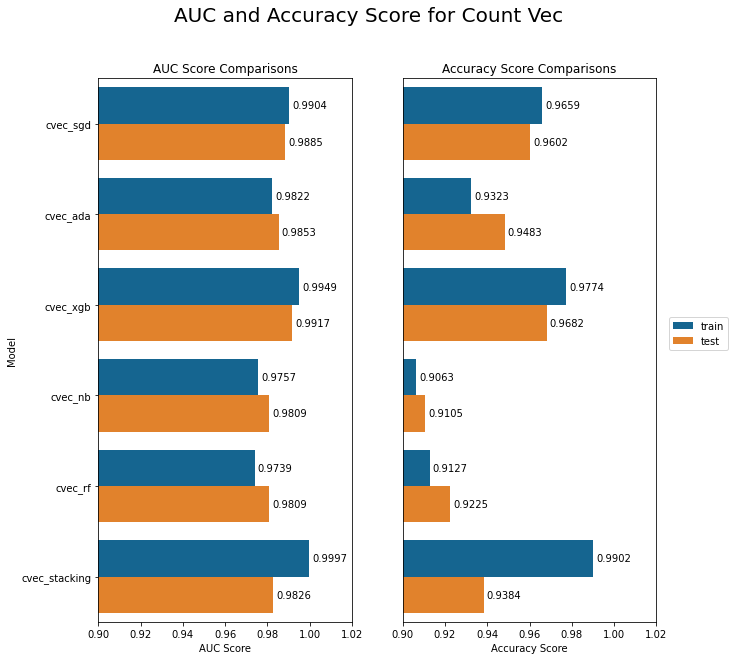

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

# Overall AUC comparison - cvec 

tidy = final_copy.loc[(final_copy['vec_type']=='cvec'),:].reset_index()[['index', 'train_auc_score', 'pred_auc_score']].melt(id_vars='index').rename(columns=str.title)
tidy['Value'] = tidy['Value'].round(4)

sns.barplot(y='Index', x='Value', hue='Variable', data=tidy, order=final_copy.loc[(final_copy['vec_type']=='cvec'),:].sort_values(by='auc_diff', ascending=True).index, ax=axes[0])

axes[0].set_xlim((0.90,1.02))
axes[0].bar_label(axes[0].containers[0], padding=3)
axes[0].bar_label(axes[0].containers[1], padding=3)
axes[0].set_title("AUC Score Comparisons")
axes[0].set_xlabel("AUC Score")
axes[0].set_ylabel("Model")
axes[0].get_legend().remove()

# Overall Accuracy comparison - cvec


tidy1 = final_copy.loc[(final_copy['vec_type']=='cvec'),:].reset_index()[['index', 'train_score', 'test_score']].melt(id_vars='index').rename(columns=str.title)
tidy1['Value'] = tidy1['Value'].round(4)
sns.barplot(y='Index', x='Value', hue='Variable', data=tidy1, order=final_copy.loc[(final_copy['vec_type']=='cvec'),:].sort_values(by='auc_diff', ascending=True).index, ax=axes[1])


axes[1].set_xlim((0.90,1.02))
axes[1].bar_label(axes[1].containers[0], padding=3)
axes[1].bar_label(axes[1].containers[1], padding=3)
axes[1].set_title("Accuracy Score Comparisons")
axes[1].get_yaxis().set_visible(False)
axes[1].set_xlabel("Accuracy Score")
axes[1].legend(loc=(1.05,0.5),handles=[axes[1].containers[0], axes[1].containers[1]], labels=['train', 'test'])

fig.suptitle("AUC and Accuracy Score for Count Vec", fontsize=20)
plt.savefig('./charts/cvec_auc_and_acc_comparison.png', bbox_inches='tight', facecolor='w', dpi=300)
plt.show()

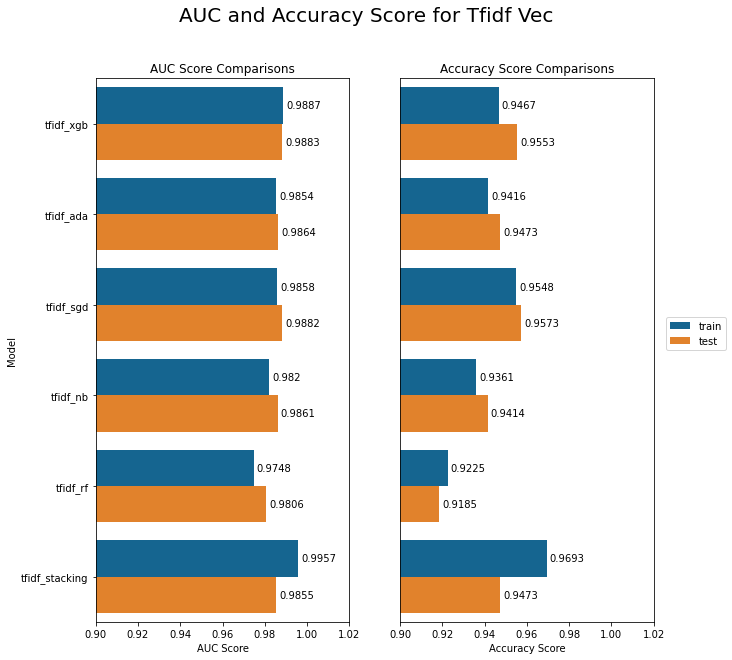

In [225]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

# Overall AUC comparison - tfidf 

tidy = final_copy.loc[(final_copy['vec_type']=='tfidf'),:].reset_index()[['index', 'train_auc_score', 'pred_auc_score']].melt(id_vars='index').rename(columns=str.title)
tidy['Value'] = tidy['Value'].round(4)

sns.barplot(y='Index', x='Value', hue='Variable', data=tidy, order=final_copy.loc[(final_copy['vec_type']=='tfidf'),:].sort_values(by='auc_diff', ascending=True).index, ax=axes[0])

axes[0].set_xlim((0.90,1.02))
axes[0].bar_label(axes[0].containers[0], padding=3)
axes[0].bar_label(axes[0].containers[1], padding=3)
axes[0].set_title("AUC Score Comparisons")
axes[0].set_xlabel("AUC Score")
axes[0].set_ylabel("Model")
axes[0].get_legend().remove()

# Overall Accuracy comparison - tfidf

tidy1 = final_copy.loc[(final_copy['vec_type']=='tfidf'),:].reset_index()[['index', 'train_score', 'test_score']].melt(id_vars='index').rename(columns=str.title)
tidy1['Value'] = tidy1['Value'].round(4)
sns.barplot(y='Index', x='Value', hue='Variable', data=tidy1, order=final_copy.loc[(final_copy['vec_type']=='tfidf'),:].sort_values(by='auc_diff', ascending=True).index, ax=axes[1])


axes[1].set_xlim((0.90,1.02))
axes[1].bar_label(axes[1].containers[0], padding=3)
axes[1].bar_label(axes[1].containers[1], padding=3)
axes[1].set_title("Accuracy Score Comparisons")
axes[1].get_yaxis().set_visible(False)
axes[1].set_xlabel("Accuracy Score")
axes[1].legend(loc=(1.05,0.5),handles=[axes[1].containers[0], axes[1].containers[1]], labels=['train', 'test'])

fig.suptitle("AUC and Accuracy Score for Tfidf Vec", fontsize=20)
plt.savefig('./charts/tfidf_auc_and_acc_comparison.png', bbox_inches='tight', facecolor='w', dpi=300)
plt.show();

Comparing the AUC scores for both count and tfidf, the best models for each are:
1. cvec_sgd for count
2. tfidf_xgb for tfidf

However, the other models are almost as good as the best models, with the max difference being 0.1 - 0.2.

Furthermore, it can also be seen that even though there are other models with lower accuracy difference, the accuracy may be sighnificantly lower than the best models. It is also best to find the balance between AUC and accuracy difference.

It can also be seen that boosting algorithms (XgBoost and AdaBoost) and SGDClassifier are the best models to use, as they are able to generalise well with the training data for both count and tfidf.

### Feature Importance

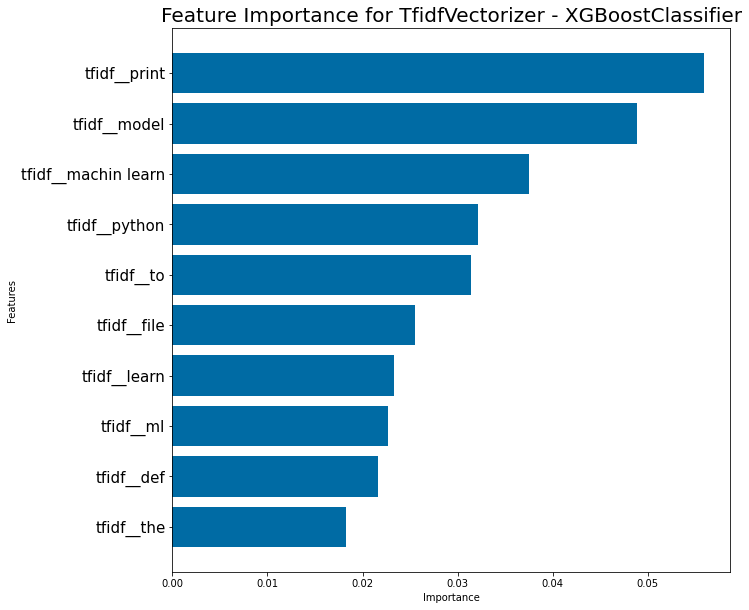

In [221]:
# Feature Importance - tfidf_xgb

with open("./model_results/tfidf_xgb_trained.pickle", "rb") as f:
    model = pickle.load(f)

importance = model.best_estimator_.named_steps['xgb'].feature_importances_

xgb_df = pd.DataFrame(importance, index=model.best_estimator_.named_steps['ct'].get_feature_names_out()).sort_values(by=0, ascending=True)

# plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))

a = plt.barh(
    data=xgb_df,
    y=xgb_df.tail(10).index, 
    width=xgb_df.tail(10)[0],
    )

# a.bar_label(container, padding=3)
plt.title("Feature Importance for TfidfVectorizer - XGBoostClassifier", fontsize=20)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.yticks(fontsize=15)
plt.savefig("./charts/tfidf_xgb_feature_importance.png", bbox_inches='tight', facecolor='w')
plt.show()

For tfidf, it is observed from the data analysis that the words print and model are the most important words which determine whether the post is learn python or learn machine learning.

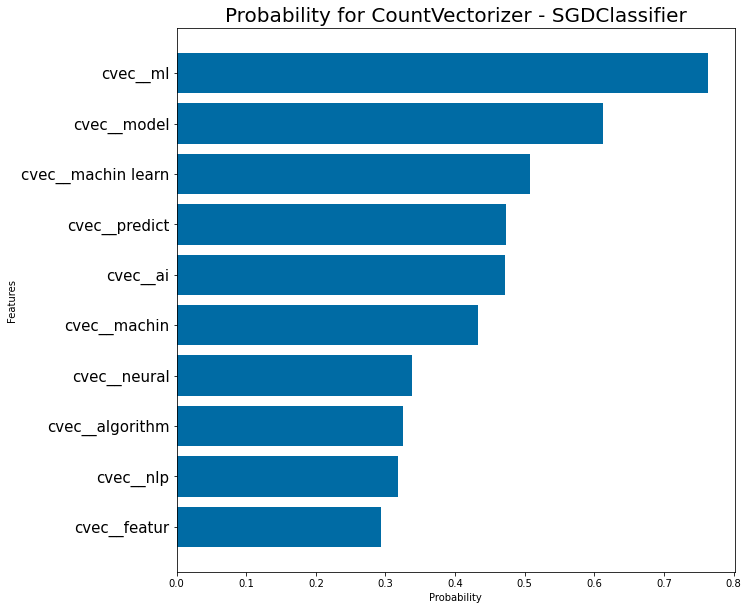

In [222]:
# Feature Importance - cvec_sgd

with open("./model_results/cvec_sgd_trained.pickle", "rb") as f:
    model = pickle.load(f)

importance = model.best_estimator_.named_steps['sgd'].coef_

sgd_df = pd.DataFrame(importance, columns=model.best_estimator_.named_steps['ct'].get_feature_names_out()).T.sort_values(by=0, ascending=True)

plt.figure(figsize=(10,10))

plt.barh(
    data=sgd_df,
    y=sgd_df.tail(10).index, 
    width=sgd_df.tail(10)[0]
    )

plt.title("Probability for CountVectorizer - SGDClassifier", fontsize=20)
plt.xlabel("Probability")
plt.ylabel("Features")
plt.yticks(fontsize=15)
plt.savefig("./charts/cvec_sgd_pred_proba.png", bbox_inches='tight', facecolor='w')
plt.show()

For count vec, the SGDClassifier does not have feature importance, but uses probability to determine the probability that if the word appears in a post, it will be more likely to be a learn machine learning post.

## See how the model fares on 'future' dataset

In [76]:
def get_future_post(subreddit, before_time, after_time, size, url="https://api.pushshift.io/reddit/search/submission"):

    posts_1 = []
    for _ in range(size):
        params = {
            "subreddit": subreddit,
            "size": 100,
            "before": before_time,
            "after": after_time,
            "sort_type": "created_utc",
        }
        res = requests.get(url, params)
        if res.status_code != 200:
            print(res.status_code)
            break
        # print(res.status_code)
        data = res.json()
        posts_1.extend(data["data"])
        # print(_)
        current_time = int(posts_1[-1]["created_utc"])

        time.sleep(1)
    return pd.DataFrame(posts_1)

In [77]:
# df_learnml = get_future_post("learnmachinelearning", before_time=int(datetime(2022, 8, 5, 0, 0, 0).timestamp()), after_time=int(datetime(2022, 7, 26, 0, 0, 0).timestamp()), size=21)
# df_learnpy = get_future_post("learnpython", before_time=int(datetime(2022, 8, 5, 0, 0, 0).timestamp()),after_time=int(datetime(2022, 7, 26, 0, 0, 0).timestamp()), size=21)

# df_new = pd.concat([df_learnml, df_learnpy], axis=0)

In [78]:
# with open("./data/future_df.pickle", 'wb') as f:
#     pickle.dump(df_new, f)

In [74]:
with open("./data/future_df.pickle", 'rb') as f:
    df_new = pickle.load(f)

In [78]:
df_new.groupby('subreddit').count()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_template_id,link_flair_text,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,thumbnail_height,thumbnail_width,url_overridden_by_dest,media,media_embed,secure_media,secure_media_embed,removed_by_category,media_metadata,crosspost_parent,crosspost_parent_list,author_flair_template_id,author_flair_text_color,author_flair_background_color
subreddit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
learnmachinelearning,2100,2100,2100,0,2100,0,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,1323,1323,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,1092,1092,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,630,630,609,168,168,168,168,105,84,21,21,0,0,0
learnpython,2100,2100,2100,63,2100,63,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,0,0,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,273,273,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,2100,0,0,21,0,0,0,0,105,0,21,21,63,84,21


In [83]:
# The earliest post extraced was on 25 July 2020, which is after 24 Jul 2022, where the training data was collected before 24 Jul 2022.

# Unseen data timeframe - earliest
display(pd.to_datetime(df_new[['created_utc']].min(), unit='s'))

# Model trained data timeframe - latest
display(pd.to_datetime(df[['created_utc']].max(), unit='s'))


created_utc   2022-07-25 16:12:24
dtype: datetime64[ns]

created_utc   2022-07-23 15:55:19
dtype: datetime64[ns]

As all the posts were taken after the training data, the data is viable to use for prediction.

In [195]:
# Extraction of features requried
df_2 = df_new[["created_utc", "title", "selftext", "subreddit"]]

In [196]:
df_2.isna().sum()

created_utc    0
title          0
selftext       0
subreddit      0
dtype: int64

In [197]:
df_2.drop(df_2.index[df_2["selftext"] == "[removed]"], inplace=True)

/tmp/ipykernel_154919/4027313610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.drop(df_2.index[df_2["selftext"] == "[removed]"], inplace=True)


In [198]:
# Change the predictor to 0 and 1
df_2["subreddit"] = df_2["subreddit"].map({"learnpython": 0, "learnmachinelearning": 1})
df_2.head()

/tmp/ipykernel_154919/3342431645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["subreddit"] = df_2["subreddit"].map({"learnpython": 0, "learnmachinelearning": 1})


,created_utc,title,selftext,subreddit
0,1658766673,Found a curious recently published experiment ...,Hey! Found a curious recently published experi...,1
1,1658766930,NLP Demystified 13: Recurrent Neural Networks ...,Hello r/learnmachinelearning:\n\nI just publis...,1
2,1658768034,Is the Andrew Ng course worth having to learn ...,"Was gonna go with doing this course, but then ...",1
3,1658772975,what are the views about freecodecamp.org and ...,I see that freecodecamp.org provides certifica...,1
4,1658773582,Help with training a model with very sparse data,"Hi all, I’m trying to train a mode that will p...",1


In [199]:
df_2[['subreddit']].value_counts(normalize=True)

subreddit
0            0.5
1            0.5
dtype: float64

In [200]:
# Combination of title and selftext

df_2['combined'] = df_2['title'] + " " + df_2['selftext']

/tmp/ipykernel_154919/114265959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['combined'] = df_2['title'] + " " + df_2['selftext']


In [201]:
X = df_2[["combined"]]
y = df_2["subreddit"]

In [205]:
# Use the best model to predict - tfidf
with open("./model_results/tfidf_xgb_trained.pickle", 'rb') as f:
    model = pickle.load(f)

results = {}

y_pred = model.predict(X)

plt.figure(figsize=(10,10), facecolor='w')
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, y_pred), display_labels=['learnpython', 'learnmachinelearning']).plot(cmap='Blues')

plt.title('Future: Confusion Matrix - tfidf')
plt.savefig("./confusion_matrix/data_future_confusion_matrix_tfidf.png", bbox_inches='tight', facecolor='w')

plt.close()

# Print different metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)

misclassification = 1 - accuracy

sensitivity = tp / (tp + fn)

specificity = tn / (tn + fp)

precision = tp / (tp + fp)

f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

prob = model.predict_proba(X)
auc_score = roc_auc_score(y, prob[:,1])

# 'Append' accuracy scores to 'results' dictinoary
results['future_tfidf'] = [
    model.score(X, y),
    misclassification,
    sensitivity,
    specificity,
    precision,
    f1,
    auc_score
]

# Use the best model to predict - cvec
with open("./model_results/cvec_sgd_trained.pickle", 'rb') as f:
    model = pickle.load(f)

y_pred = model.predict(X)
# print(classification_report(y_test, y_pred))

plt.figure(figsize=(10,10), facecolor='w')
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, y_pred), display_labels=['learnpython', 'learnmachinelearning']).plot(cmap='Blues')

plt.title('Future: Confusion Matrix - cvec')
plt.savefig("./confusion_matrix/data_future_confusion_matrix_cvec.png", bbox_inches='tight', facecolor='w')

plt.close()

# Print different metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)

misclassification = 1 - accuracy

sensitivity = tp / (tp + fn)

specificity = tn / (tn + fp)

precision = tp / (tp + fp)


f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

prob = model.predict_proba(X)
auc_score = roc_auc_score(y, prob[:,1])

# 'Append' accuracy scores to 'results' dictinoary
results['future_cvec'] = [
    model.score(X, y),
    misclassification,
    sensitivity,
    specificity,
    precision,
    f1,
    auc_score
]

[00:13:09] WARNING: ../src/gbm/gbtree.cc:390: Loading from a raw memory buffer on CPU only machine.  Changing tree_method to hist.
[00:13:09] WARNING: ../src/learner.cc:248: No visible GPU is found, setting `gpu_id` to -1


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [207]:
results_df_new = pd.DataFrame(results, index=["score","misclassification", "sensitivity", "specificity", "precision", 'f1', 'auc_score'])

with open("./data/future_results.pickle", "wb") as f:
    pickle.dump(results_df_new, f)

In [208]:
results_df_new

,future_tfidf,future_cvec
score,0.978947,0.973684
misclassification,0.021053,0.026316
sensitivity,0.968421,0.957895
specificity,0.989474,0.989474
precision,0.989247,0.989130
f1,0.978723,0.973262
auc_score,0.995346,0.993241


In general, we can see that both models are able to predict well on 'future' unseen posts. Both the accuracy and the auc score are about the same for each model.

## Conclusions/Recommendations

**Conclusions:**
1. Both countvectorizer and tfidfvectorizer are viable methods for the modeling process. 
2. As seen from the result evaluation, most models are able to perform well, with exceptional generalisation from SGDClassifier and boosting algorithms (Adaboost and xGBoost).

**Recommendations:**
1. The model is not perfect, as spam posts were removed from the data. In reality, there would always be spam posts. Further improvement/modeling can be done to include the classification of the spam posts.
2. Different sub-reddits can be used and tested on, as the chosen subreddits are quite different, which generally gave all models very good generalisation.